# Eoin Molloy - September 2023


This notebook solves the steady state heat conduction equation in a 2D square plate using the finite volume method

In [21]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import time
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import spsolve


In [22]:
def HeatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb):
    '''
    Solves steady state heat equation in 2D using the finite volume method for a plate subjected to surface 
    temperatures on its 4 sides

    Arguments:
        Lx, Ly: Dimensions of plate in x and y direction - unit: (m)
        Nx, Ny: Number of cells for mesh in x and y directions - no unit
        Tl, Tr, Tt, Tb: Surface temperature on plate on left, right, top and bottom sides - unit: (degrees C)
        k: thermal conductivity of plate material - unit: (W/mK)
    
    Returns:
        T: Column vector specifiyng temperature value of every cell centre - unit: (degrees C)
    '''
    
    '''
    Mesh Info
    '''
    #grid spacing
    dx = Lx/Nx
    dy = Ly/Ny
    
    # total number of cells
    M = int(Nx*Ny)
    
    #get indices of corner cells
    botright = Nx-1
    topleft = Nx*(Ny-1)
    topright = Nx*Ny-1
    
    '''
    Coefficients
    '''
    #east and west face coefficients equal i.e. along x direction
    ax = k*dy/dx
    #north and south face coefficients equal i.e. along y direction
    ay = k*dx/dy
    ap = -2*(ax+ay)
    
    
    '''
    Initialise Linear System
    '''
    T = np.zeros((M, 1)) #Initialise temperature vector
    
    b = np.zeros((M, 1)) #Initialise source vector
    
    '''
    CSR Matrix
    '''
    # 3 coeffs on each corner + 4 coeffs on each cell attached to a side
    #+ 5 coeffs on each internal cell
    internalandcorner = 3*4+5*(Nx-2)*(Ny-2)
    sides =  4*(2*Nx+2*Ny-8)
    numNonZeros = internalandcorner+sides
    
    data = np.zeros((numNonZeros))
    row_idx = np.zeros((numNonZeros ))
    col_idx = np.zeros((numNonZeros ))
    coeffi=0
    '''
    Build Linear system
    '''
    
    for i in range(0, M):#Loop through each cell i
        #CORNERS
        #bottom left...  Te and Tn unknown, Tw and Tb known (at boundary)
        if i == 0:
            #compute constant for this equation
            b[i] = -2*ay*Tb-2*ax*Tl
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1 #move to next coefficient
            
            
            
        #bottom right
        elif i == botright:
             #compute constant for this equation
            b[i] = -2*ay*Tb-2*ax*Tr
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            
        #top left
        elif i == topleft:
             #compute constant for this equation
            b[i] = -2*ay*Tt-2*ax*Tl
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #top right
        elif i == topright:
             #compute constant for this equation
            b[i] = -2*ay*Tt-2*ax*Tr
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -3*ax-3*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #SIDES
        #bottom
        elif 0 < i < botright:
             #compute constant for this equation
            b[i] = -2*ay*Tb
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ax -(3.0)*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
        
        #top
        elif topleft < i < topright:
            #compute constant for this equation
            b[i] = -2*ay*Tt
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ax -(3.0)*ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficien
        #left
        elif i in range(Nx,topleft,Nx):
            #compute constant for this equation
            b[i] = -2*ax*Tl
            
            #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ay -(3.0)*ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
        #right
        elif i in range(botright+Nx,topright,Nx):
            #compute constant for this equation
            b[i] = -2*ax*Tr
             #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = -2*ay -(3.0)*ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
        else:
            b[i] = 0
             #INSERT COEFFICIENTS
            
            #centre
            data[coeffi] = ap 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i
            col_idx[coeffi] = i
            
            coeffi+=1#move to next coefficient
            
            #south
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-Nx 
            
            coeffi+=1#move to next coefficient
            
            #west
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i-1 
            
            coeffi+=1#move to next coefficient
            
            #north
            data[coeffi] = ay 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+Nx 
            
            coeffi+=1#move to next coefficient
            
            #east
            data[coeffi] = ax 
            #set row and col position from sparse matrix
            row_idx[coeffi] = i 
            col_idx[coeffi] = i+1 
            
            coeffi+=1#move to next coefficient
    
    '''
    Solve System
    '''
    #create sparse coefficient matrix
    A = csr_matrix((data, (row_idx, col_idx)), shape=(M, M))
    t = time.time()
    #solve set of simultaneous equations
    T = scipy.sparse.linalg.spsolve(A, b)
    print('Time to solve the linear system = ', time.time() - t)
        
    '''
    Contour Plot
    '''
    X,Y = np.meshgrid(np.arange(0,Lx,dx),np.arange(0,Ly,dy))
    T_plot = np.reshape(T, (Ny, Nx))
    plt.figure()
    plt.contourf(X,Y,T_plot,cmap='inferno')
    plt.colorbar(label="Temperature (C)")
    plt.ylabel("Ly (m)")
    plt.xlabel("Lx (m)")
    plt.title('Temperature Distribution in Plate',fontsize= 13)
    plt.show()
        

    return T

In [23]:
Lx = 1
Ly = 1
Nx = 100
Ny = 100
k = 45
Tl = 0
Tt = 70
Tr = 0
Tb = 0

#### Run Simulation

Time to solve the linear system =  0.03155684471130371


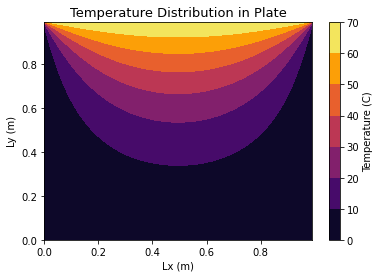

In [24]:
T = HeatConduction(Lx,Ly,Nx,Ny,k,Tl,Tr,Tt,Tb)
